In [237]:
!pip install torch torchvision

In [238]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [239]:
# load labels
df_train_labels = pd.read_csv('data/train_labels.csv')
print(df_train_labels.shape)
df_train_labels.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [240]:
# load some tif images
from PIL import Image

labels_name = ["No cancerous", "Cancerous"]

def get_tif_image_nparray(img):
    imarray = np.array(img)
    return imarray

def plot_tif_image(image, label=None):
    plt.figure(figsize=(4, 4))
    if label is not None:
        plt.title(labels_name[int(label)])
    plt.imshow(get_tif_image_nparray(image))    
    
def plot_image(image, label=None):
    plt.figure(figsize=(4, 4))
    if label is not None:
        plt.title(labels_name[int(label)])
    plt.imshow(image)
    
def plot_id_image(id):
    label = df_train_labels[df_train_labels.id == id].label.values[0]
    filename = "data/train/%s.tif" % id
    img = Image.open(filename)
    plot_tif_image(img, label)



to overfit:  0.40503124644926713


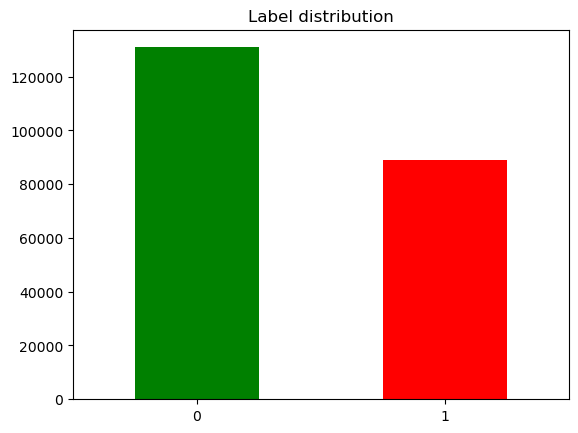

In [241]:
# Label distribution
df_train_labels['label'].value_counts().plot(kind='bar', title='Label distribution', rot=0, color=['green', 'red'])
print("to overfit: ", df_train_labels[df_train_labels['label'] == 1].shape[0] / df_train_labels.shape[0])

In [242]:
# Image size
load_tif_image("data/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif").shape

(96, 96, 3)

In [243]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset

In [244]:
import os

class CustomDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.labels = df
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.labels.iloc[index, 0] + '.tif')
        label = float(self.labels.iloc[index, 1])
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.labels)


In [245]:
from sklearn.model_selection import train_test_split
train_df, validation_df = train_test_split(df_train_labels, test_size=0.07, random_state=42)

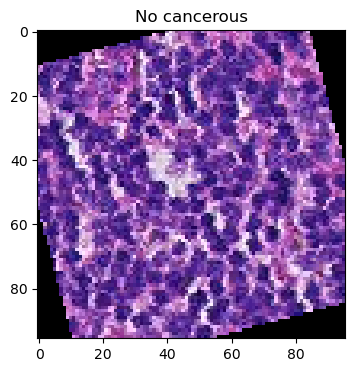

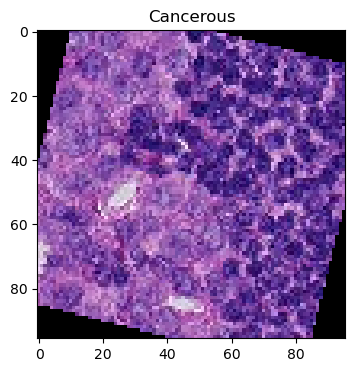

In [246]:
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_df, 'data/train/', transform=transform)
validation_dataset = CustomDataset(validation_df, 'data/train/', transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=512, shuffle=True)
for i, (images, labels) in enumerate(validation_dataloader):
    if i == 2:
        break   
    images = images.numpy().transpose(0, 2, 3, 1)
    plot_image(images[0], labels[0])


In [247]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from model import ConvNet

In [248]:
def evaluate(model, loader, criterion):
    correct = 0
    total = 0
    total_loss = 0
    
    for images, labels in iter(loader):
        outputs = model(images).squeeze()
        # set dtype to float32
        labels = labels.type(torch.FloatTensor)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        outputs = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()
        for i in range(len(outputs)):
            if outputs[i] >= 0.5:
                outputs[i] = 1
            else:
                outputs[i] = 0
        correct += np.sum(outputs == labels)
        total += len(labels)    

    acc = correct / total
    return acc, total_loss / len(loader)


In [254]:
# Create the ConvNet model and optimizer
model = ConvNet()
model = model.to(device)
epsilon = 0.0002
min_epsilon = 0.0001
optimizer = optim.Adam(model.parameters(), lr=epsilon)

# Train the model
loss_history = []
acc_history = []
num_epochs = 13
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        # set dtype to float32
        labels = labels.type(torch.FloatTensor)
        loss = nn.functional.binary_cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if (i+1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')
            # update learning rate

        if (i) % 100 == 0:
            acc, loss = evaluate(model, validation_dataloader, nn.functional.binary_cross_entropy)
            acc_history.append((acc, loss))
            print(f'Validation   : {acc:.4f}, Validation Loss: {loss:.4f}')
        if (i+1) % 300 == 0:
            torch.save(model.state_dict(), f'models/checkpoint_{epoch+1}_{i+1}.pth')



Validation   : 0.5972, Validation Loss: 0.6903
Epoch [1/13], Step [20/1599], Loss: 0.7041
Epoch [1/13], Step [40/1599], Loss: 0.6746
Epoch [1/13], Step [60/1599], Loss: 0.6545
Epoch [1/13], Step [80/1599], Loss: 0.5951
Epoch [1/13], Step [100/1599], Loss: 0.5795
Validation   : 0.7475, Validation Loss: 0.5413
Epoch [1/13], Step [120/1599], Loss: 0.5306
Epoch [1/13], Step [140/1599], Loss: 0.5503
Epoch [1/13], Step [160/1599], Loss: 0.5204
Epoch [1/13], Step [180/1599], Loss: 0.5090
Epoch [1/13], Step [200/1599], Loss: 0.4693
Validation   : 0.7689, Validation Loss: 0.4968
Epoch [1/13], Step [220/1599], Loss: 0.4234
Epoch [1/13], Step [240/1599], Loss: 0.5065
Epoch [1/13], Step [260/1599], Loss: 0.5437
Epoch [1/13], Step [280/1599], Loss: 0.4968
Epoch [1/13], Step [300/1599], Loss: 0.5613
Validation   : 0.7842, Validation Loss: 0.4705
Epoch [1/13], Step [320/1599], Loss: 0.4868
Epoch [1/13], Step [340/1599], Loss: 0.4522
Epoch [1/13], Step [360/1599], Loss: 0.4444
Epoch [1/13], Step [380/

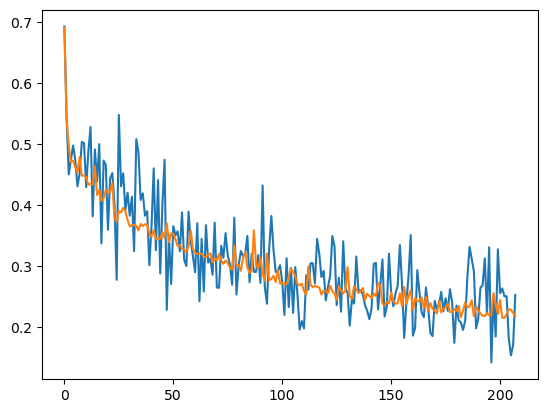

In [255]:
plt.plot(loss_history[::100])
plt.plot([x[1] for x in acc_history], label='Loss')

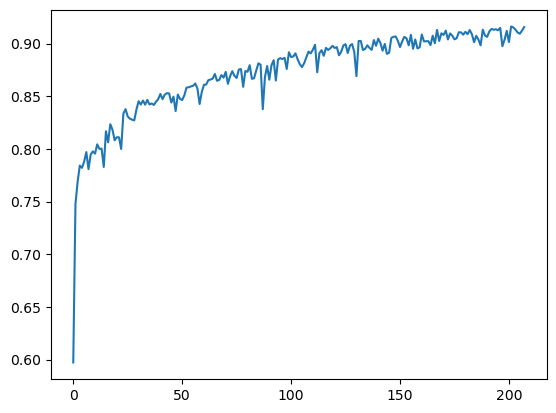

In [256]:
plt.plot([x[0] for x in acc_history], label='Accuracy')


In [257]:
torch.save(model.state_dict(), "modelV3.pth")

In [253]:
conti = input("Continue training? (y/n): ")

# Continue training
model = torch.load("modelV2.pth")
